# Isyaratku With ResNet50

description maybe

## Import Libraries

In [ ]:
import tensorflow as tf
import tensorflow.lite as tflite
import cv2
import numpy as np
import pandas as pd
import string
import sklearn
import matplotlib.pyplot as plt
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split

from IPython.display import clear_output
import os

In [ ]:
!pip install kaggle

## Import Data

In [ ]:
!kaggle datasets download -d agungmrf/indonesian-sign-language-bisindo
!kaggle datasets download -d ayuraj/asl-dataset

Dataset URL: https://www.kaggle.com/datasets/agungmrf/indonesian-sign-language-bisindo
License(s): unknown
100% 1.36G/1.36G [00:29<00:00, 49.3MB/s]
100% 1.36G/1.36G [00:29<00:00, 49.5MB/s]
Dataset URL: https://www.kaggle.com/datasets/ayuraj/asl-dataset
License(s): CC0-1.0
 72% 41.0M/56.9M [00:00<00:00, 43.6MB/s]
100% 56.9M/56.9M [00:00<00:00, 60.1MB/s]


In [ ]:
!mkdir ./datasets
!rm -rf sample_data

!unzip -o indonesian-sign-language-bisindo.zip -d datasets/indonesian-sign-language-bisindo
!unzip -o asl-dataset.zip -d datasets/asl

clear_output()

In [ ]:
!ls -al ./datasets/

total 20
drwxr-xr-x 4 root root 4096 Jun  5 08:02 .
drwxr-xr-x 1 root root 4096 Jun  5 08:02 ..
drwxr-xr-x 3 root root 4096 Jun  5 08:02 asl
drwxr-xr-x 3 root root 4096 Jun  5 08:02 indonesian-sign-language-bisindo


## Use GPU If available

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    tf.config.set_visible_devices(gpus[0], 'GPU')

Num GPUs Available:  1


## BISINDO

### Data Preparation and Exploration

In [ ]:
images_train = '/content/datasets/indonesian-sign-language-bisindo/bisindo/images/train'
labels_train = '/content/datasets/indonesian-sign-language-bisindo/bisindo/labels/train'

images_test = '/content/datasets/indonesian-sign-language-bisindo/bisindo/images/val'
labels_test = '/content/datasets/indonesian-sign-language-bisindo/bisindo/labels/val'

In [ ]:
def dataset(dir):
  path = []

  for letter in os.listdir(dir):
    letter_dir = os.path.join(dir, letter)

    for name in os.listdir(letter_dir):
      path.append(os.path.join(letter_dir, name))
  return path

In [ ]:
b_images_train = dataset(images_train)
b_labels_train = dataset(labels_train)

b_images_test = dataset(images_test)
b_labels_test = dataset(labels_test)

In [ ]:
print(f'There are {len(b_images_train)} images for training')
print(f'There are {len(b_labels_train)} labels for training')
print(f'There are {len(b_images_test)} images for test')
print(f'There are {len(b_labels_test)} labels for test')

There are 9169 images for training
There are 9168 labels for training
There are 2301 images for test
There are 2301 labels for test


### Try without the given label

In [ ]:
label_dict = {}
x=0
for folder in os.listdir(images_train):
    label_dict[x] = folder
    x+=1

print(label_dict)

{0: 'K', 1: 'I', 2: 'H', 3: 'X', 4: 'S', 5: 'B', 6: 'T', 7: 'V', 8: 'O', 9: 'Q', 10: 'Z', 11: 'P', 12: 'W', 13: 'C', 14: 'Y', 15: 'E', 16: 'F', 17: 'G', 18: 'D', 19: 'J', 20: 'N', 21: 'L', 22: 'U', 23: 'M', 24: 'R', 25: 'A'}


In [ ]:
from tqdm import tqdm

def load_and_label_images(images_path, label_dict):
    X = []
    y = []
    for key, value in label_dict.items():
        path = os.path.join(images_path, value)
        print(value, key)

        for img in tqdm(os.listdir(path)):
            img_array = cv2.imread(os.path.join(path, img))
            new_array = cv2.resize(img_array, (200, 200))
            X.append(new_array)
            y.append(key)
    return X, y

In [ ]:
X_train, y_train = load_and_label_images(images_train, label_dict)
X_test, y_test = load_and_label_images(images_test, label_dict)

K 0


100%|██████████| 348/348 [00:02<00:00, 165.41it/s]


I 1


100%|██████████| 360/360 [00:02<00:00, 171.12it/s]


H 2


100%|██████████| 348/348 [00:02<00:00, 116.29it/s]


X 3


100%|██████████| 355/355 [00:02<00:00, 161.25it/s]


S 4


100%|██████████| 343/343 [00:02<00:00, 166.41it/s]


B 5


100%|██████████| 351/351 [00:02<00:00, 162.65it/s]


T 6


100%|██████████| 360/360 [00:02<00:00, 163.03it/s]


V 7


100%|██████████| 357/357 [00:02<00:00, 133.48it/s]


O 8


100%|██████████| 357/357 [00:02<00:00, 124.24it/s]


Q 9


100%|██████████| 348/348 [00:02<00:00, 166.87it/s]


Z 10


100%|██████████| 360/360 [00:02<00:00, 172.93it/s]


P 11


100%|██████████| 357/357 [00:01<00:00, 187.82it/s]


W 12


100%|██████████| 360/360 [00:02<00:00, 169.77it/s]


C 13


100%|██████████| 343/343 [00:02<00:00, 122.70it/s]


Y 14


100%|██████████| 328/328 [00:02<00:00, 138.71it/s]


E 15


100%|██████████| 352/352 [00:02<00:00, 163.44it/s]


F 16


100%|██████████| 357/357 [00:02<00:00, 168.59it/s]


G 17


100%|██████████| 360/360 [00:02<00:00, 171.14it/s]


D 18


100%|██████████| 348/348 [00:02<00:00, 171.05it/s]


J 19


100%|██████████| 360/360 [00:03<00:00, 110.25it/s]


N 20


100%|██████████| 350/350 [00:02<00:00, 168.84it/s]


L 21


100%|██████████| 357/357 [00:02<00:00, 174.29it/s]


U 22


100%|██████████| 355/355 [00:02<00:00, 169.57it/s]


M 23


100%|██████████| 355/355 [00:02<00:00, 165.02it/s]


R 24


 91%|█████████▏| 320/350 [00:02<00:00, 124.03it/s]

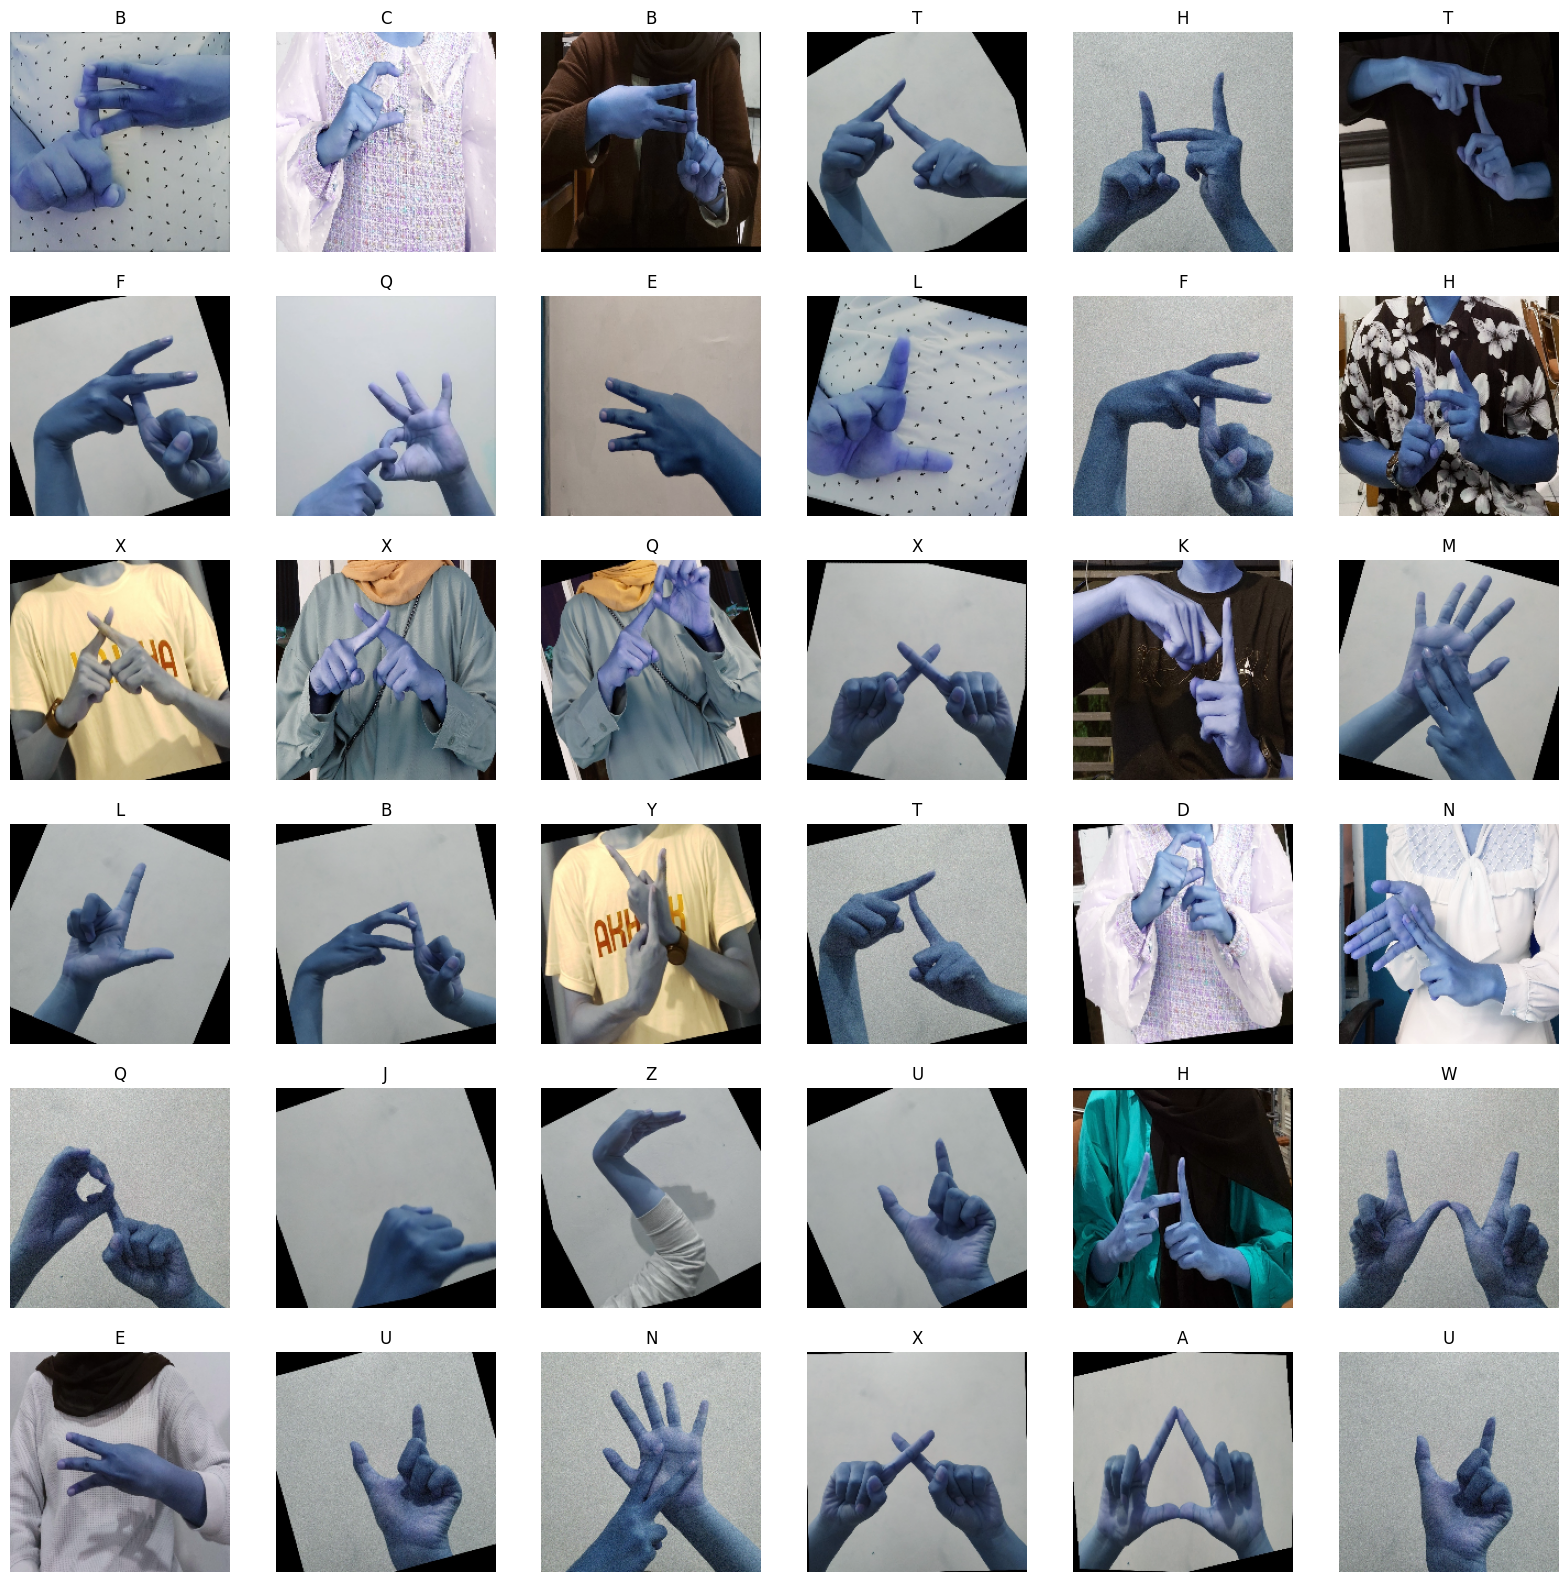

In [ ]:
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(X_train),36))) :
    plt.subplot(6,6,n+1)
    plt.imshow(X_train[i])
    plt.axis('off')
    plt.title(dict[y_train[i]])

In [ ]:
X_train=np.array(X_train)
y_train=np.array(y_train)

print(X_train.shape)
print(y_train.shape)

(9169, 200, 200, 3)
(9169,)


In [ ]:
X_test=np.array(X_test)
y_test=np.array(y_test)

print(X_test.shape)
print(y_test.shape)

(2301, 200, 200, 3)
(2301,)


### Build and Create Base Model

### Build Sequential Model Architecture


In [ ]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (5, 5), activation='relu', input_shape=(200,200,3)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(4, 4)),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Conv2D(64, (5, 5), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(4, 4)),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Conv2D(128, (5, 5), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(4, 4)),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(26, activation='softmax')
    ])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, epochs=10)

### Review Training Curves and Metrics

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Accuracy: {accuracy*100:.2f} %")

72/72 [==============================] - 1s 13ms/step - loss: 0.3988 - accuracy: 0.8683
Accuracy: 86.83 %


In [ ]:
y_pred = model.predict(X_test)
y_pred = [np.argmax(i) for i in y_pred]

72/72 [==============================] - 1s 8ms/step


Text(0.5, 135.7222222222222, 'Predicted Labels')

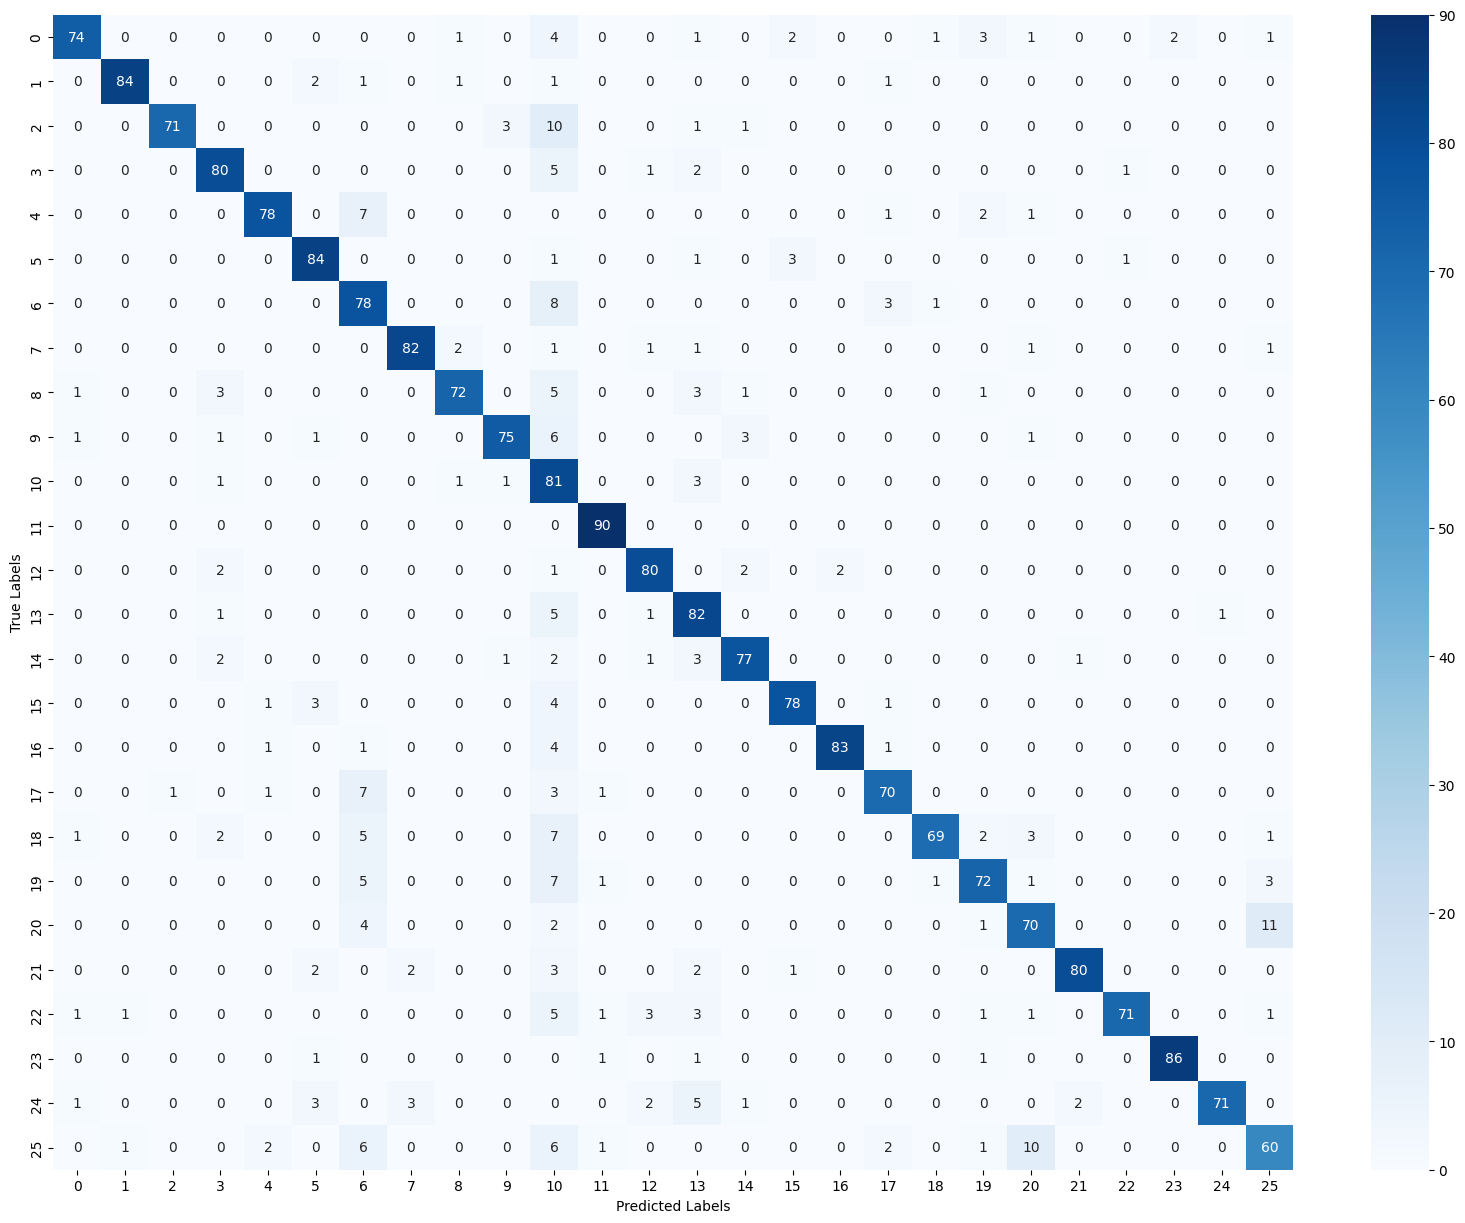

In [ ]:
import seaborn as sns
from tensorflow.math import confusion_matrix

plt.figure(figsize=(20,15))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.82      0.88        90
           1       0.98      0.93      0.95        90
           2       0.99      0.83      0.90        86
           3       0.87      0.90      0.88        89
           4       0.94      0.88      0.91        89
           5       0.88      0.93      0.90        90
           6       0.68      0.87      0.76        90
           7       0.94      0.92      0.93        89
           8       0.94      0.84      0.88        86
           9       0.94      0.85      0.89        88
          10       0.47      0.93      0.63        87
          11       0.95      1.00      0.97        90
          12       0.90      0.92      0.91        87
          13       0.76      0.91      0.83        90
          14       0.91      0.89      0.90        87
          15       0.93      0.90      0.91        87
          16       0.98      0.92      0.95        90
          17       0.89    

### Hyperparameter Tuning and Reconfigure Layers

### Convert to TFLite

### Save Model

## ASL

### Data Preparation and Exploration

In [ ]:
asl_set = '/content/datasets/asl/asl_dataset/asl_dataset'

#### Create label

In [ ]:
letter = set(string.ascii_lowercase)
for name in os.listdir(asl_set):
  subfolder = os.path.join(asl_set, name)
  if os.path.isdir(subfolder) and name not in letter:
        shutil.rmtree(subfolder)

In [ ]:
asl_label = {}
x=0
for folder in sorted(os.listdir(asl_set)):
    asl_label[x] = folder
    x+=1

print(asl_label)

{0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h', 8: 'i', 9: 'j', 10: 'k', 11: 'l', 12: 'm', 13: 'n', 14: 'o', 15: 'p', 16: 'q', 17: 'r', 18: 's', 19: 't', 20: 'u', 21: 'v', 22: 'w', 23: 'x', 24: 'y', 25: 'z'}


In [ ]:
asl_images, asl_labels = load_and_label_images(asl_set, asl_label)

a 0


100%|██████████| 70/70 [00:00<00:00, 337.37it/s]


b 1


100%|██████████| 70/70 [00:00<00:00, 389.02it/s]


c 2


100%|██████████| 70/70 [00:00<00:00, 419.60it/s]


d 3


100%|██████████| 70/70 [00:00<00:00, 596.35it/s]


e 4


100%|██████████| 70/70 [00:00<00:00, 566.95it/s]


f 5


100%|██████████| 70/70 [00:00<00:00, 565.52it/s]


g 6


100%|██████████| 70/70 [00:00<00:00, 616.96it/s]


h 7


100%|██████████| 70/70 [00:00<00:00, 611.85it/s]


i 8


100%|██████████| 70/70 [00:00<00:00, 527.85it/s]


j 9


100%|██████████| 70/70 [00:00<00:00, 530.96it/s]


k 10


100%|██████████| 70/70 [00:00<00:00, 556.24it/s]


l 11


100%|██████████| 70/70 [00:00<00:00, 599.31it/s]


m 12


100%|██████████| 70/70 [00:00<00:00, 579.32it/s]


n 13


100%|██████████| 70/70 [00:00<00:00, 530.40it/s]


o 14


100%|██████████| 70/70 [00:00<00:00, 569.03it/s]


p 15


100%|██████████| 70/70 [00:00<00:00, 594.30it/s]


q 16


100%|██████████| 70/70 [00:00<00:00, 596.50it/s]


r 17


100%|██████████| 70/70 [00:00<00:00, 613.95it/s]


s 18


100%|██████████| 70/70 [00:00<00:00, 570.38it/s]


t 19


100%|██████████| 65/65 [00:00<00:00, 377.84it/s]


u 20


100%|██████████| 70/70 [00:00<00:00, 575.56it/s]


v 21


100%|██████████| 70/70 [00:00<00:00, 620.80it/s]


w 22


100%|██████████| 70/70 [00:00<00:00, 606.89it/s]


x 23


100%|██████████| 70/70 [00:00<00:00, 615.68it/s]


y 24


100%|██████████| 70/70 [00:00<00:00, 553.20it/s]


z 25


100%|██████████| 70/70 [00:00<00:00, 526.29it/s]


In [ ]:
asl_images_train, asl_images_test, asl_labels_train, asl_labels_test = train_test_split(asl_images, asl_labels, test_size=0.2, random_state=10, shuffle=True)

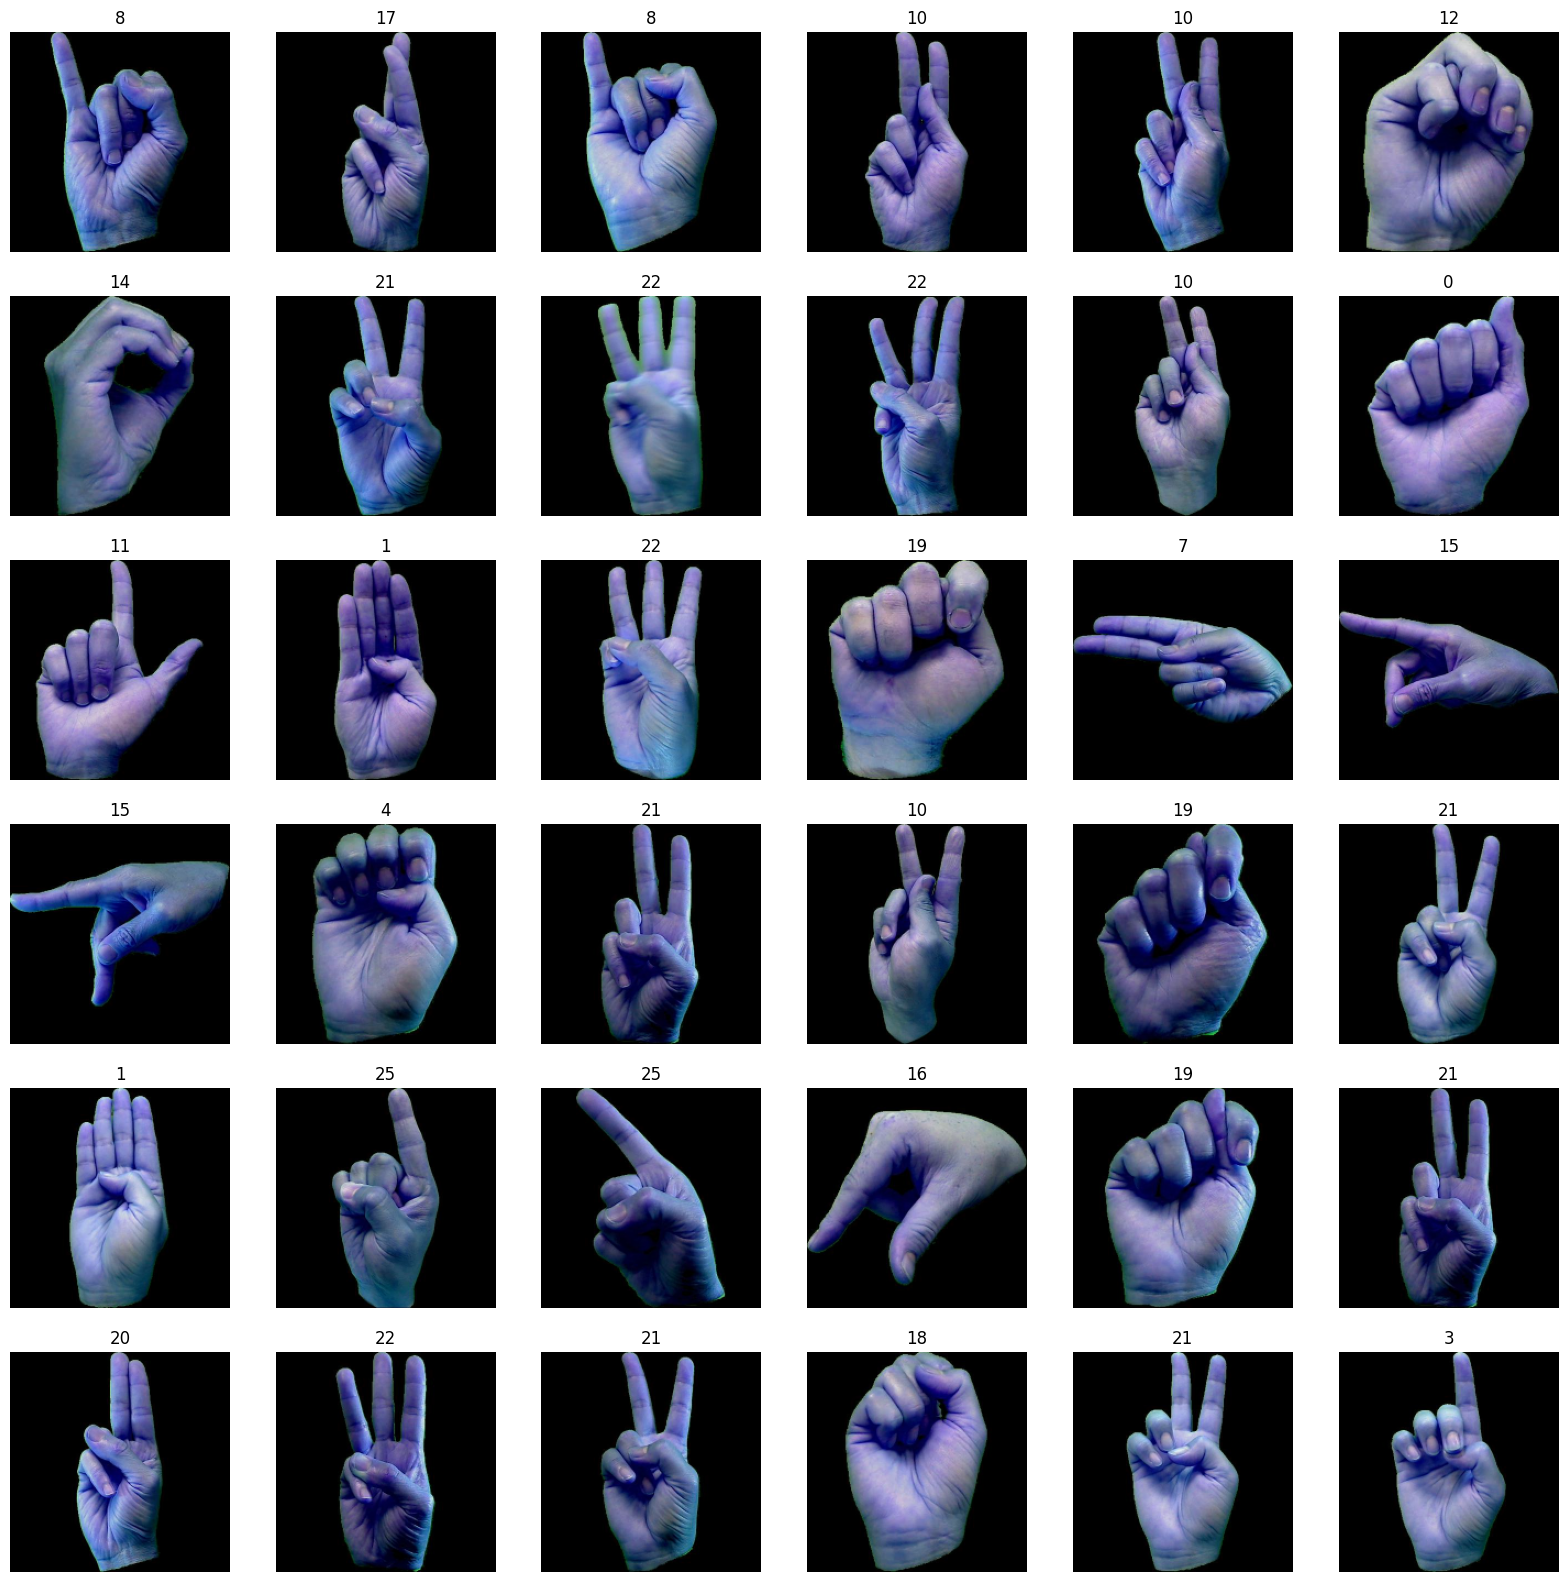

In [ ]:
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(asl_images_train),36))) :
    plt.subplot(6,6,n+1)
    plt.imshow(asl_images_train[i])
    plt.axis('off')
    plt.title(asl_labels_train[i])

In [ ]:
asl_images_train=np.array(asl_images_train)
asl_labels_train=np.array(asl_labels_train)

print(asl_images_train.shape)
print(asl_labels_train.shape)

(1452, 200, 200, 3)
(1452,)


In [ ]:
asl_images_test=np.array(asl_images_test)
asl_labels_test=np.array(asl_labels_test)

print(asl_images_test.shape)
print(asl_labels_test.shape)

(363, 200, 200, 3)
(363,)


#### Augmentation

In [ ]:
def generators(train_images, train_labels, test_images, test_labels):

  train_generator = ImageDataGenerator(rescale=1./255.,
                                      rotation_range=10,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      )
  asl_train_data = train_generator.flow(x = train_images,
                                        y = train_labels,
                                        batch_size = 20)

  test_generator = ImageDataGenerator(rescale=1./255.)
  asl_test_data = test_generator.flow(x = test_images,
                                      y = test_labels,
                                      batch_size = 20)
  return asl_train_data, asl_test_data

In [ ]:
asl_train_data, asl_test_data = generators(asl_images_train, asl_labels_train, asl_images_test, asl_labels_test)

### Configure and Train Model

In [ ]:
model.fit(asl_train_data, epochs=100, validation_data=asl_test_data)

Epoch 1/100
73/73 [==============================] - 25s 217ms/step - loss: 4.1402 - accuracy: 0.0675 - val_loss: 3.2496 - val_accuracy: 0.0882
Epoch 2/100
73/73 [==============================] - 16s 216ms/step - loss: 3.3754 - accuracy: 0.1350 - val_loss: 3.3214 - val_accuracy: 0.0303
Epoch 3/100
73/73 [==============================] - 16s 222ms/step - loss: 2.9754 - accuracy: 0.1853 - val_loss: 5.1081 - val_accuracy: 0.0303
Epoch 4/100
73/73 [==============================] - 15s 205ms/step - loss: 2.6987 - accuracy: 0.2397 - val_loss: 4.3484 - val_accuracy: 0.0909
Epoch 5/100
73/73 [==============================] - 15s 200ms/step - loss: 2.4612 - accuracy: 0.2810 - val_loss: 3.2848 - val_accuracy: 0.1377
Epoch 6/100
73/73 [==============================] - 15s 204ms/step - loss: 2.2041 - accuracy: 0.3209 - val_loss: 3.6002 - val_accuracy: 0.1047
Epoch 7/100
73/73 [==============================] - 16s 215ms/step - loss: 2.0245 - accuracy: 0.3726 - val_loss: 3.7294 - val_accuracy:

### Review Training Curves and Metrics

In [ ]:
loss, accuracy = model.evaluate(asl_test_data)
print(f"Accuracy: {accuracy*100:.2f} %")

19/19 [==============================] - 0s 12ms/step - loss: 0.0429 - accuracy: 0.9890
Accuracy: 98.90 %


In [ ]:
asl_labels_pred = model.predict(asl_images_test)
asl_labels_pred = [np.argmax(i) for i in asl_labels_pred]

12/12 [==============================] - 1s 23ms/step


Text(0.5, 135.7222222222222, 'Predicted Labels')

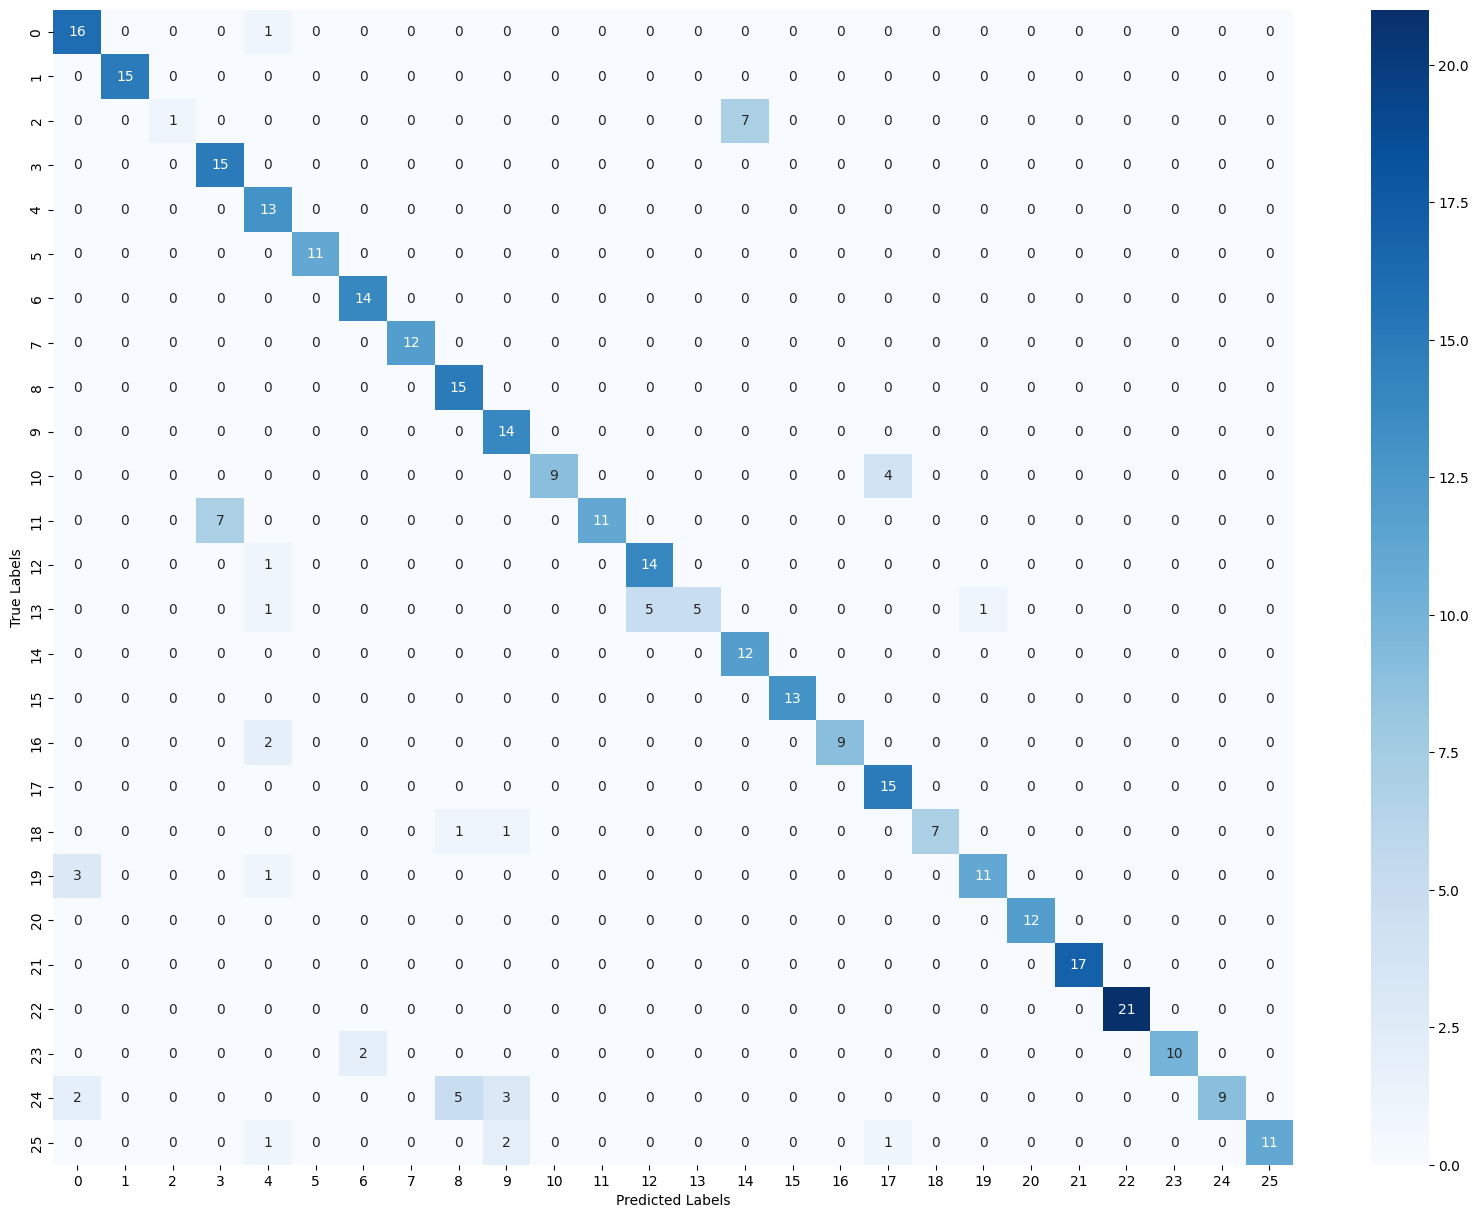

In [ ]:
import seaborn as sns
from tensorflow.math import confusion_matrix

plt.figure(figsize=(20,15))
sns.heatmap(confusion_matrix(asl_labels_test, asl_labels_pred), annot=True, fmt='d', cmap='Blues')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(asl_labels_test, asl_labels_pred))

              precision    recall  f1-score   support

           0       0.76      0.94      0.84        17
           1       1.00      1.00      1.00        15
           2       1.00      0.12      0.22         8
           3       0.68      1.00      0.81        15
           4       0.65      1.00      0.79        13
           5       1.00      1.00      1.00        11
           6       0.88      1.00      0.93        14
           7       1.00      1.00      1.00        12
           8       0.71      1.00      0.83        15
           9       0.70      1.00      0.82        14
          10       1.00      0.69      0.82        13
          11       1.00      0.61      0.76        18
          12       0.74      0.93      0.82        15
          13       1.00      0.42      0.59        12
          14       0.63      1.00      0.77        12
          15       1.00      1.00      1.00        13
          16       1.00      0.82      0.90        11
          17       0.75    

### Hyperparameter Tuning and Reconfigure Layers

### Convert to TFLite

In [ ]:
# Save the trained model
model.save('asl_model.h5')

# Convert the model to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model to a file
with open('asl_model.tflite', 'wb') as f:
    f.write(tflite_model)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Save Model

In [ ]:
model.save('asl_model.h5')
model.save('asl_saved_model', save_format='tf')

## SANDBOX

In [ ]:
def architecture_coba():
  model_coba = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=(28, 28,1)),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(25, activation='softmax')
  ])

  model_coba.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])
  return model_coba

In [ ]:
model_coba = architecture_coba()
model_coba.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 26, 26, 128)       1280      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 13, 13, 128)       0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 13, 13, 128)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 11, 11, 64)        73792     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 5, 5, 64)         

In [ ]:
history_coba = model_coba.fit(asl_train_data, epochs=100, validation_data=asl_test_data, batch_size=20)

NameError: name 'asl_train_data' is not defined

In [ ]:
# Save the trained model
model_coba.save('asl_model.h5')

# Convert the model to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model_coba)
tflite_model = converter.convert()

# Save the TFLite model to a file
with open('asl_model.tflite', 'wb') as f:
    f.write(tflite_model)